# Comparison of scenarios

post review version, run the `generate_alternative_scenarios.py` script first.
From analysis_opt_newFIG

In [27]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os
import tqdm

output_directory = 'model_output/2021-11-17/'
output_prefix = f'altstratint'

# New builder
when = 'future-mobintime'
nnodes = 107
ndays = 90
setup_shared = ItalySetupProvinces(nnodes, ndays, when)
scenarios = {pick_scenario(setup_shared, i)['name']: pick_scenario(setup_shared, i) for i in np.arange(2,11+1)}
summary = pd.DataFrame()
for scn_name, scn in scenarios.items():
    summary = pd.concat([summary, pd.read_csv(f'{output_directory}/{output_prefix}-{scn_name}-ALL.csv')])
    

#summary = pd.read_csv(f'{output_directory}/{output_prefix}-ALL.csv')
summary.replace('U', 'Pessimistic', inplace=True)
summary.replace('L', 'Optimistic', inplace=True)
summary.replace('Population per hab. (focused)', 'Equal (focused)', inplace=True)
summary.replace('Population per hab. (proportional)', 'Equal (proportional)', inplace=True)
summary

Loaded Italy Provincial Setup with 107 nodes.


,method_short,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,newdoseperweek
0,sus_pp_f,Susceptible per hab. (focused),7.549615e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
1,sus_f,Susceptible (focused),7.457979e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
2,sus_pp_p,Susceptible per hab. (proportional),7.355315e+06,1,1.625602e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
3,sus_p,Susceptible (proportional),7.369131e+06,1,1.625597e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
4,pop_pp_f,Equal (focused),7.556871e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000
...,...,...,...,...,...,...,...,...,...,...
1525,inc_pp_p,Incidence per hab. (proportional),7.400189e+05,102,1.951951e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000
1526,inc_p,Incidence (proportional),7.451350e+05,102,1.952005e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000
1527,opt,Optimal,7.129481e+05,102,1.950000e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000
1528,Gre,Greedy,7.952319e+05,102,1.928571e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000


In [28]:
summary['averted'] = 0
for ps in tqdm.tqdm(summary['post_sample'].unique()):
    for bs in summary['scenario-beta'].unique():
        n_infected_baseline = summary[(summary['method_short'] == 'nov')&(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected'].iloc[0]
        summary.loc[(summary['post_sample']==ps)&(summary['scenario-beta']==bs), 'averted'] = float(n_infected_baseline) - summary[(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected']
        #print(n_infected_baseline - summary[(summary['post_sample']==ps)&(summary['scenario-beta']==bs)]['infected'])
summary['avertedpervacc'] = summary['averted']/summary['doses']

# 
summary['averted-wrt2opt'] = 0
summary_opt = summary[summary['method']=='Optimal']
for ps in tqdm.tqdm(summary['post_sample'].unique()):
        for sn in summary['scenario'].unique():
            averted_by_opt = summary[(summary['method_short'] == 'opt')&(summary['post_sample']==ps)&(summary['scenario']==sn)]['averted']
            summary.loc[(summary['post_sample']==ps)&(summary['scenario']==sn), 'averted-wrt2opt'] = \
                    summary.loc[(summary['post_sample']==ps)&(summary['scenario']==sn), 'averted']/float(averted_by_opt)*100
            
summary['averted-wrt2opt102'] = 0
summary_opt = summary[(summary['method']=='Optimal')&(summary['post_sample']==102)]
for sn in tqdm.tqdm(summary['scenario'].unique()):
    averted_by_opt_102 = summary[(summary['method_short'] == 'opt')&(summary['post_sample']==102)&(summary['scenario']==sn)]['averted']
    summary.loc[(summary['scenario']==sn), 'averted-wrt2opt102'] = \
                    summary.loc[(summary['scenario']==sn), 'averted']/float(averted_by_opt_102)*100
summary

100%|██████████| 10/10 [00:00<00:00, 213.06it/s]


,method_short,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,newdoseperweek,averted,avertedpervacc,averted-wrt2opt,averted-wrt2opt102
0,sus_pp_f,Susceptible per hab. (focused),7.549615e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,3.610152e+05,0.222163,4.274393e+01,5.373746e+01
1,sus_f,Susceptible (focused),7.457979e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,4.526510e+05,0.278554,5.359353e+01,6.737752e+01
2,sus_pp_p,Susceptible per hab. (proportional),7.355315e+06,1,1.625602e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,5.553150e+05,0.341606,6.574887e+01,8.265916e+01
3,sus_p,Susceptible (proportional),7.369131e+06,1,1.625597e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,5.414989e+05,0.333108,6.411306e+01,8.060263e+01
4,pop_pp_f,Equal (focused),7.556871e+06,1,1.625000e+06,Pessimistic,r15,t125000,U-r15-t125000-id2,125000,3.537589e+05,0.217698,4.188479e+01,5.265735e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,inc_pp_p,Incidence per hab. (proportional),7.400189e+05,102,1.951951e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000,5.449300e+05,0.027917,9.526735e+01,9.526735e+01
1526,inc_p,Incidence (proportional),7.451350e+05,102,1.952005e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000,5.398139e+05,0.027654,9.437293e+01,9.437293e+01
1527,opt,Optimal,7.129481e+05,102,1.950000e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000,5.720008e+05,0.029333,1.000000e+02,1.000000e+02
1528,Gre,Greedy,7.952319e+05,102,1.928571e+07,Optimistic,r15,t1500000,L-r15-t1500000-id11,1500000,4.897169e+05,0.025393,8.561473e+01,8.561473e+01


In [29]:
smry[(smry['scenario-tot'] == 't479700')&(smry['post_sample'] == 1)]

,method_short,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,newdoseperweek,averted,avertedpervacc,averted-wrt2opt,averted-wrt2opt102
2,sus_pp_p,Susceptible per hab. (proportional),6.101255e+06,1,6.238615e+06,Pessimistic,r15,t479700,U-r15-t479700-id6,479'700,1.809375e+06,0.290028,75.712753,106.486632
7,pop_p,Population (proportional),6.079509e+06,1,6.238393e+06,Pessimistic,r15,t479700,U-r15-t479700-id6,479'700,1.831122e+06,0.293525,76.622723,107.766464
10,inc_pp_p,Incidence per hab. (proportional),5.730429e+06,1,6.238660e+06,Pessimistic,r15,t479700,U-r15-t479700-id6,479'700,2.180201e+06,0.349466,91.229847,128.310737
12,opt,Optimal,5.520841e+06,1,6.236100e+06,Pessimistic,r15,t479700,U-r15-t479700-id6,479'700,2.389789e+06,0.383219,100.000000,140.645568
2,sus_pp_p,Susceptible per hab. (proportional),1.519824e+06,1,6.238548e+06,Optimistic,r15,t479700,L-r15-t479700-id7,479'700,3.750929e+05,0.060125,69.027324,112.396566
7,pop_p,Population (proportional),1.517870e+06,1,6.238393e+06,Optimistic,r15,t479700,L-r15-t479700-id7,479'700,3.770469e+05,0.060440,69.386919,112.982091
10,inc_pp_p,Incidence per hab. (proportional),1.402374e+06,1,6.238736e+06,Optimistic,r15,t479700,L-r15-t479700-id7,479'700,4.925428e+05,0.078949,90.641321,147.590441
12,opt,Optimal,1.351519e+06,1,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,479'700,5.433977e+05,0.087137,100.000000,162.829093


/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/frame.py:4385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


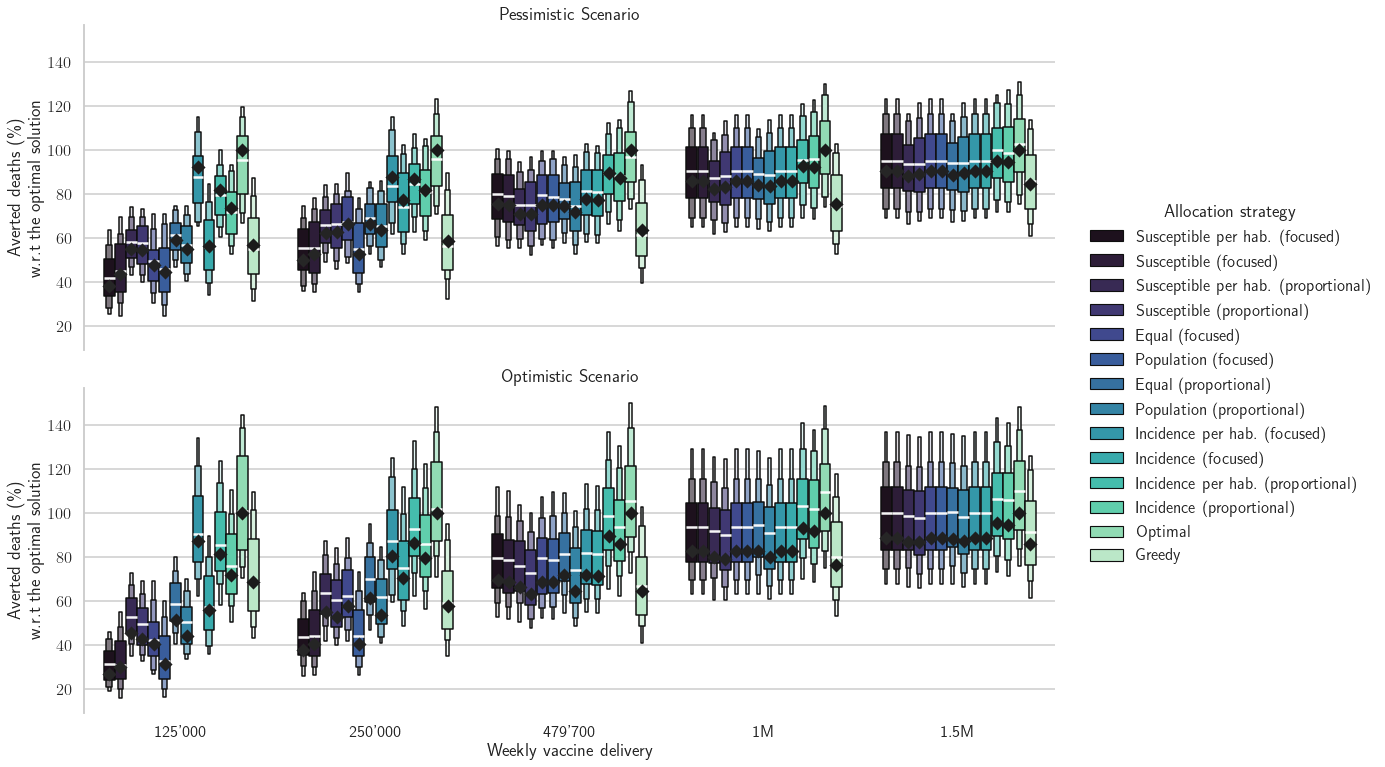

In [8]:
methods = ['sus_pp_f', 'sus_f', 'sus_pp_p', 'sus_p', 'pop_pp_f', 'pop_f',
       'pop_pp_p', 'pop_p', 'inc_pp_f', 'inc_f', 'inc_pp_p', 'inc_p', 'Gre',
       'opt'] #summary['method_short'].unique() - 'nov'
#methods = ['opi', 'finc','fincpp', 'pincpp']
#methods = ['opi', 'pinc','ppop', 'psus']

toplot = "averted-wrt2opt102"
#var_x = "scenario-rate"  
var_x = "newdoseperweek" 

dpw = summary['newdoseperweek'].unique()
dpw = [125000,250000,479700, 1000000,1500000]#, 2000000]
#dpw = [ 479700, 1000000, 1500000, 2000000]

#smry = summary[(summary['scenario-tot']=='t479700') & (summary['method'].isin(methods))]

smry = summary[(summary['scenario-rate']=='r15') & (summary['method_short'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))]#.sort_values('method_short')
smry.newdoseperweek = smry.newdoseperweek.astype(str)
smry.replace('125000', "125'000", inplace=True)
smry.replace('479700', "479'700", inplace=True)
smry.replace('250000', "250'000", inplace=True)
smry.replace('1000000', "1M", inplace=True)
smry.replace('1500000', "1.5M", inplace=True)
smry.replace('2000000', "2M", inplace=True)

sns.set_theme(style="whitegrid")
sns.set_context("talk")
mpl.rc('text', usetex=True)
#mpl.rc('font', size=25)
#mpl.rc('legend', fontsize=24)

grid = sns.FacetGrid(smry, 
                     col="scenario-beta",  
                     palette="mako", 
                     height=5.5, 
                     aspect = 2, col_wrap=1, sharey=True,sharex=True, legend_out=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):

    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="mako",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        saturation=1,
        #linewidth=0
        #width=.
        
        )
    ax = plt.gca()
    #ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.legend(loc = 'upper left')
    plt.setp(ax.collections, zorder=100, label="")
    
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(2.5)
        line.set_alpha(10)


# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")
g = grid

#grid.add_legend(title='Allocation strategy', loc='center right',bbox_to_anchor=(1,0.57),frameon=True, framealpha=1)

#for ax in g.axes.flat:
#    box = ax.get_position()
#    ax.set_position([box.x0,box.y0,box.width*0.85,box.height])

leg = grid.add_legend(title='Allocation strategy', loc='center left',bbox_to_anchor=(1,0.5))


def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==102) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
        color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=10, 
        linewidths = 10,
        edgecolors = 'k',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)
grid.despine(bottom=True)

#grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_axis_labels("Weekly vaccine delivery","Averted deaths (\%) \n w.r.t the optimal solution",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}", fontsize=40, fontweight='bold')
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/SI_scenarios_perturb_all.pdf', bbox_inches='tight')

In [18]:
a = smry[(smry['post_sample']==102)].pivot_table(columns= ['scenario-beta'], index = ['newdoseperweek', 'method'], values = ['averted', 'avertedpervacc']).sort_values(by=('averted', 'Optimistic'), ascending=False)
a['averted'] = a['averted']/1e6
print(a.to_latex(float_format="{:0.17g}".format).replace('e+06','M').replace('averted}', 'averted (Millions)}'))

\begin{tabular}{llrrrr}
\toprule
        & {} & \multicolumn{2}{l}{averted (Millions)} & \multicolumn{2}{l}{avertedpervacc} \\
        & scenario-beta &           Optimistic &         Pessimistic &           Optimistic &         Pessimistic \\
newdoseperweek & method &                      &                     &                      &                     \\
\midrule
1.5M & Optimal &  0.57200081608748399 &  3.0325945358421293 & 0.029333375176045423 & 0.15551766846530438 \\
        & Incidence per hab. (proportional) &  0.54492999743102011 &  2.8875373011978245 & 0.027917197623047677 & 0.14793271370598579 \\
        & Incidence (proportional) &  0.53981392436735087 &  2.8748355393724356 & 0.027654330090909233 & 0.14727859290967568 \\
        & Equal (focused) &  0.50721301006194508 &  2.7484423503259801 &  0.02601092359292026 & 0.14094576155517846 \\
        & Incidence (focused) &  0.50721301006194508 &  2.7484423503259801 &  0.02601092359292026 & 0.14094576155517849 \\
        & Incid

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/pandas/core/frame.py:4385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


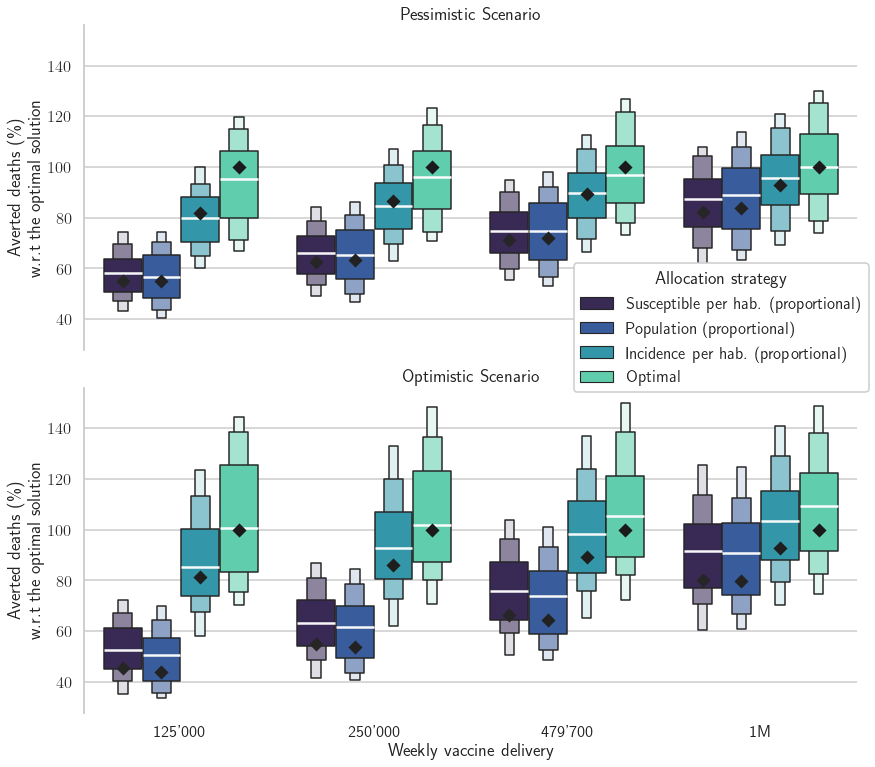

In [19]:
methods = ['sus_pp_p', 'pop_p','inc_pp_p', 'opt'] 
dpw = [125000,250000,479700, 1000000]
smry = summary[(summary['scenario-rate']=='r15') & (summary['method_short'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))]
smry.newdoseperweek = smry.newdoseperweek.astype(str)
smry.replace('125000', "125'000", inplace=True)
smry.replace('479700', "479'700", inplace=True)
smry.replace('250000', "250'000", inplace=True)
smry.replace('1000000', "1M", inplace=True)
smry.replace('1500000', "1.5M", inplace=True)
smry.replace('2000000', "2M", inplace=True)

sns.set_theme(style="whitegrid")
sns.set_context("talk")
mpl.rc('text', usetex=True)
#mpl.rc('font', size=25)
#mpl.rc('legend', fontsize=24)

grid = sns.FacetGrid(smry, 
                     col="scenario-beta",  
                     palette="mako", 
                     height=5.5, 
                     aspect = 1.5, col_wrap=1, sharey=True,sharex=True, legend_out=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="mako",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        saturation=1,
        #linewidth=0
        #width=.
    )
    ax = plt.gca()
    #ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.legend(loc = 'upper left')
    plt.setp(ax.collections, zorder=100, label="")
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(2.5)
        line.set_alpha(10)


# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")
g = grid

grid.add_legend(title='Allocation strategy', loc='center right',bbox_to_anchor=(1,0.57),frameon=True, framealpha=1)

for ax in g.axes.flat:
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.85,box.height])

def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==102) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
        color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=10, 
        linewidths = 10,
        edgecolors = 'k',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)
grid.despine(bottom=True)

#grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_axis_labels("Weekly vaccine delivery","Averted deaths (\%) \n w.r.t the optimal solution",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}", fontsize=40, fontweight='bold')
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [6]:
a = smry[(smry['post_sample']==102)].pivot_table(columns= ['scenario-beta'], index = ['newdoseperweek', 'method'], values = ['averted', 'avertedpervacc']).sort_values(by=('averted', 'Optimistic'), ascending=False)
a['averted'] = a['averted']/1e6
print(a.to_latex(float_format="{:0.2g}".format).replace('e+06','M').replace('averted}', 'averted (Millions)}'))

\begin{tabular}{llrrrr}
\toprule
        & {} & \multicolumn{2}{l}{averted (Millions)} & \multicolumn{2}{l}{avertedpervacc} \\
        & scenario-beta & Optimistic & Pessimistic &     Optimistic & Pessimistic \\
newdoseperweek & method &            &             &                &             \\
\midrule
1M & Optimal &       0.48 &         2.5 &          0.037 &         0.2 \\
        & Incidence per hab. (focused) &        0.4 &         2.2 &          0.031 &        0.17 \\
        & Population (focused) &        0.4 &         2.2 &          0.031 &        0.17 \\
        & Susceptible per hab. (focused) &        0.4 &         2.2 &          0.031 &        0.17 \\
479'700 & Optimal &       0.33 &         1.7 &          0.054 &        0.27 \\
        & Incidence per hab. (focused) &       0.24 &         1.3 &          0.038 &        0.21 \\
        & Susceptible per hab. (focused) &       0.23 &         1.3 &          0.037 &        0.21 \\
        & Population (focused) &       0.23 &

# Part 2. Analysis of an optimal solution
From analysis_ts